In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.special import gammaln, digamma
import itertools
from tqdm import tqdm

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Modelling the 'true' ball force as a GP with a squared exponential kernel

We assume that the force of the ball is a Gaussian process with a squared exponential kernel. The kernel is defined as follows:
$$
k(x, x') = \alpha^2 \exp\left(-\frac{1}{2l^2} (x - x')^2\right)
$$
where $\alpha$ is the amplitude and $l$ is the length scale. We assume that the ball is pushed at the beginning of the game, and that the force is constant throughout the game. The force is sampled from a Gaussian process with the above kernel. The mean of the Gaussian process is a cosine function with a period of $2\pi/6$ and an amplitude of $0.5$. The mean is shifted by $5$ units to the right. The variance of the Gaussian process is $\sigma^2 = k(x, x)$. The following figure shows the mean and the variance of the Gaussian process.

    x1: 2D array of shape (m,n) representing the first dimension of the input grid
    x2: 2D array of shape (m,n) representing the second dimension of the input grid
    mu: 1D array of shape (m*n,) representing the mean function evaluated at the input grid
    sigma: 2D array of shape (m*n,m*n) representing the covariance matrix
    n_sample: int, number of samples to generate

In [9]:
def rbf(x, alpha=0.05, length=0.1):
    sqdist = np.sum(x**2, axis=1)[:, None] + np.sum(x**2, axis=1)[None, :] - 2 * np.dot(x, x.T)
    sigma = alpha**2 * np.exp(-0.5 * sqdist / length**2)
    return sigma

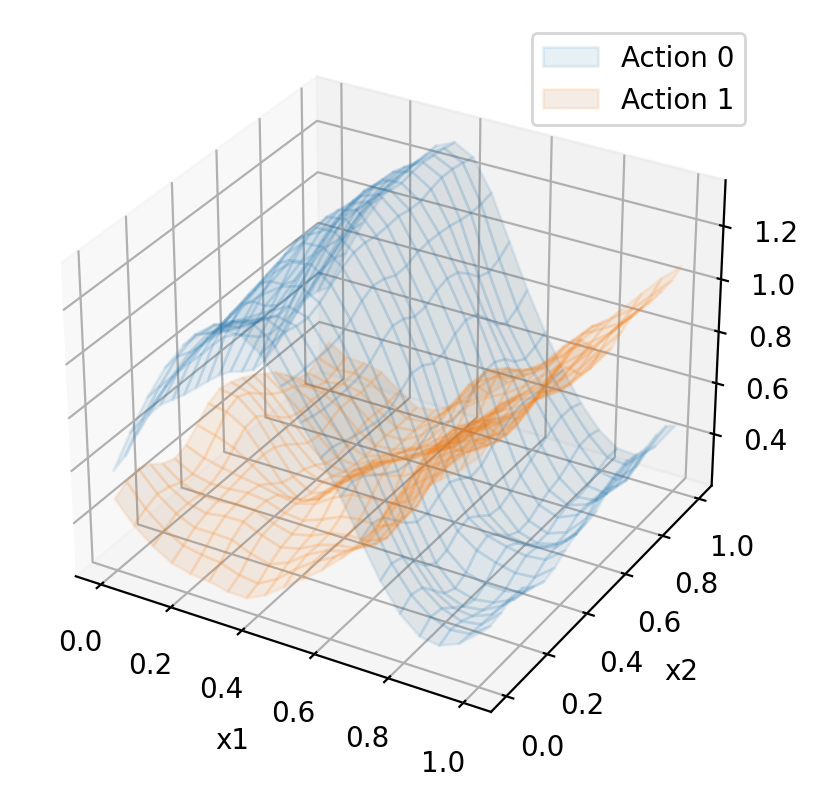

In [10]:
# Define the input grid
n_x1 = 20
n_x2 = 20
n_x = n_x1 * n_x2

x1 = np.linspace(0, 1.0, n_x1)
x2 = np.linspace(0, 1.0, n_x2)
x = np.column_stack([_x.ravel() for _x in np.meshgrid(x1, x2)])


# Define the covariance function
sigma = rbf(x)

n_dim = x.shape[-1]
n_sample = 1
y = np.zeros((n_dim, n_sample, n_x))

# Generate samples for while "not pushing" or "pushing" the ball (action '0' and '1') 
mu = np.zeros((2, n_x))
mu[0] = 0.8 + 0.5*np.cos(6*x[:,0] - 2) # + 0.3*np.sin(4*x[:,1] + 3)
mu[1] = 0.8 + 0.5*np.cos(3*x[:,0] - 4) # + 0.3*np.sin(4*x[:,1] + 3)
for i in range(2):
    y[i] = np.random.multivariate_normal(mu[i], sigma, n_sample)

# Plot the samples 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for y_idx in range(y.shape[0]):
    for sample in range(n_sample):
        surf = ax.plot_surface(
            *np.meshgrid(x1, x2), y[y_idx, sample].reshape(np.meshgrid(x1, x2)[0].shape), 
            label=f'Action {y_idx}', 
            rstride=1, cstride=1, alpha=0.1, 
            color=f"C{y_idx}", edgecolor=f"C{y_idx}")
        
        surf._edgecolors2d = surf._edgecolor3d
        surf._facecolors2d = surf._facecolor3d

ax.legend()

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')

plt.show()

# Moving to a discrete world

In [11]:
n_timestep = 6
n_velocity = 20
n_action = 2
n_position = 50

timestep = np.linspace(0, 1.0, n_timestep)
position = np.linspace(0, 2.0, n_position)
velocity = np.linspace(0., 3.0, n_velocity)
action = np.arange(n_action)

max_velocity = 10.0
friction_factor = 0.5

n_sample = 300

## Building the velocity transaction matrix

In [15]:
# Compute the 'true' transition probabilities for the velocity
seed = 123
np.random.seed(seed)

# def rbf(_x, alpha=0.05, length=0.1):
#     sq_dist = (
#         np.sum(_x**2, axis=1)[:, None]
#         + np.sum(_x**2, axis=1)[None, :]
#         - 2 * np.dot(_x, _x.T)
#     )
#     sigma = alpha**2 * np.exp(-0.5 * sq_dist / length**2)
#     return sigma

assert len(action) == 2, "Only two actions are supported"

n_timestep = len(timestep)
n_position = len(position)
n_velocity = len(velocity)
n_action = len(action)

x = np.column_stack([x.ravel() for x in np.meshgrid(timestep, position)])

mu = np.zeros((2, n_timestep * n_position))
mu[0] = 0.8 + 0.6 * np.cos(6 * x[:, 0] - 2)  # + 0.3*np.sin(4*x[:,1] + 3)
mu[1] = 0.8 + 0.7 * np.cos(3 * x[:, 0] - 4)  # + 0.3*np.sin(4*x[:,1] + 3)

transition_velocity_tapvv = np.zeros(
    (n_timestep, n_action, n_position, n_velocity, n_velocity)
)
for a in action:
    force = np.random.multivariate_normal(mu[a], rbf(x), size=n_sample)
    force = force.reshape(n_sample, n_timestep, n_position)

    for v_idx, v in enumerate(velocity):
        for t_idx, t in enumerate(timestep):
            for p_idx, p in enumerate(position):

                new_v = np.zeros(n_sample)
                new_v += v - friction_factor * v
                new_v += force[:, t_idx, p_idx]
                new_v = np.clip(new_v, min(velocity), max(velocity))
                hist, bins = np.histogram(
                    new_v, bins=list(velocity) + [2 * velocity[-1] - velocity[-2]]
                )
                sum_hist = np.sum(hist)
                if sum_hist > 0:
                    density = hist / sum_hist
                else:
                    density = hist
                transition_velocity_tapvv[t_idx, a, p_idx, v_idx, :] = density

#### Visualizing the velocity transition matrix

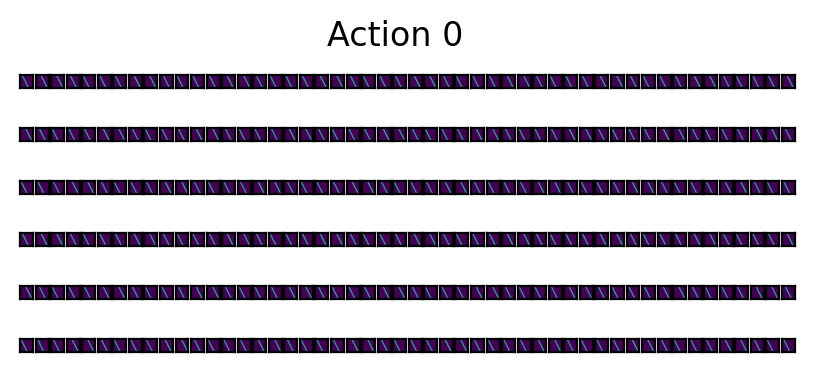

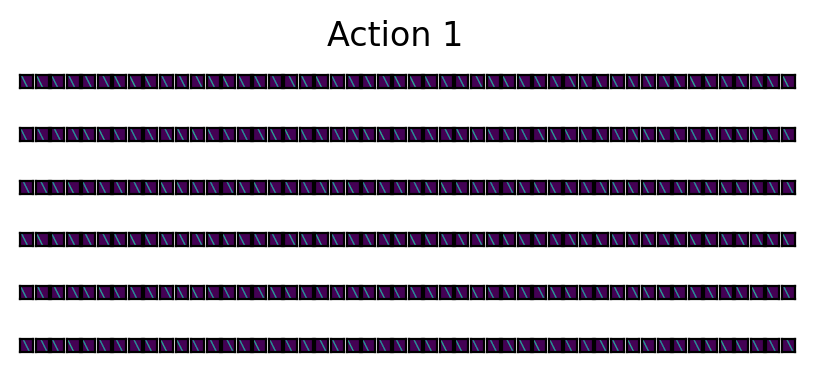

In [16]:
for a_idx in range(n_action):  
    fig, axes = plt.subplots(ncols=n_position, nrows=n_timestep, figsize=(5, 2))
    for i in range(n_action):
        for t_idx in range(n_timestep):
            for p_idx in range(n_position):
                ax = axes[t_idx, p_idx]
                img = transition_velocity_tapvv[t_idx, a_idx, p_idx, :, :]
                ax.imshow(img, aspect=1)
                ax.get_xaxis().set_ticks([])
                ax.axes.get_yaxis().set_ticks([])
                
    fig.suptitle(f"Action {a_idx}")
    plt.show()

## Computing the position transition matrix

In [17]:
n_timestep = len(timestep)
n_position = len(position)
n_velocity = len(velocity)

transition_position_pvp = np.zeros((n_position, n_velocity, n_position))
dt = (max(timestep) - min(timestep)) / (n_timestep - 1)
dp = (max(position) - min(position)) / (n_position - 1)
for p_idx, p in enumerate(position):
    for v_idx, v in enumerate(velocity):
        for p2_idx, p2 in enumerate(position):
            transition_position_pvp[p_idx, v_idx, p2_idx] = norm.pdf(
                p2, loc=p + dt * v, scale=dp / 4
            )
        denominator = transition_position_pvp[p_idx, v_idx, :].sum()
        if denominator == 0:
            # Handle division by zero here
            # For example, set the result to a specific value
            transition_position_pvp[p_idx, v_idx, :] = 0
        else:
            transition_position_pvp[p_idx, v_idx, :] /= denominator

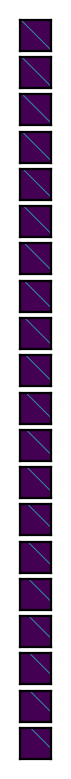

In [18]:
fig, axes = plt.subplots(nrows=n_velocity)
for i, ax in enumerate(axes):
    img = transition_position_pvp[:, i, :]
    ax.imshow(img, aspect=1)
    ax.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

# Running the environment

In [19]:
all_hist_pos = {}
all_hist_vel = {}

n_sample_run = 20

policies = ["all-one", "all-zero", "random", "max-expected-velocity"]
for policy in policies:

    hist_pos = np.zeros((n_sample_run, n_timestep))
    hist_vel = np.zeros_like(hist_pos)

    for sample in range(n_sample_run):

        p_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        np.random.seed(123 + sample*123)

        for t_idx, t in enumerate(timestep):

            if policy == "all-one":
                a = 1
            elif policy == "all-zero":
                a = 0
            elif policy == "random":
                a = np.random.choice([0, 1])
            elif policy == "max-expected-velocity":
                e_v = np.zeros(2)
                for a in range(2):
                    e_v[a] = np.average(velocity, weights=transition_velocity_tapvv[t_idx, a, p_idx, v_idx, :])
                a = e_v.argmax()
            else:
                raise ValueError
            tr_vel = transition_velocity_tapvv[t_idx, a, p_idx, v_idx, :]
            # print(t_idx, a, p_idx, v_idx)
            v_idx = np.random.choice(np.arange(n_velocity), p=tr_vel)
            tr_pos = transition_position_pvp[p_idx, v_idx, :]
            p_idx = np.random.choice(np.arange(n_position), p=tr_pos)

            hist_pos[sample, t_idx] = position[p_idx]
            hist_vel[sample, t_idx] = velocity[v_idx]

        all_hist_pos[policy] = hist_pos
        all_hist_vel[policy] = hist_vel

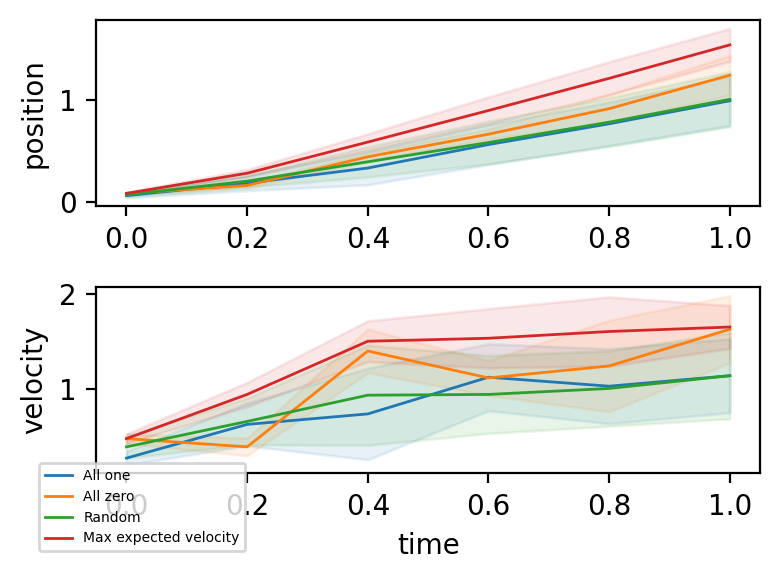

In [20]:
def plot_runs(policies, all_hist_pos, all_hist_vel):
    fig, axes = plt.subplots(nrows=2, figsize=(4, 3))
    for i, policy in enumerate(policies):
        label = policy.replace("-", " ").capitalize()
        pos = all_hist_pos[policy].mean(axis=0)
        pos_disp = all_hist_pos[policy].std(axis=0)
        vel = all_hist_vel[policy].mean(axis=0)
        vel_disp = all_hist_vel[policy].std(axis=0)
        x = np.linspace(0, 1, n_timestep)
        if label.startswith("Af"):
            label = label.replace("Af", "Active inference -")
            linewidth = 2
            if label.endswith("epistemic"):
                linestyle = ":"
                linewidth = 4
            elif label.endswith("pragmatic"):
                linestyle = "-."
            else:
                label = label.replace(" -", "")
                linestyle = "--"
        else:
            linestyle, linewidth = "-", 1
        axes[0].plot(x, pos, color=f"C{i}", label=label, linestyle=linestyle, linewidth=linewidth)
        axes[0].fill_between(x, pos - pos_disp, pos + pos_disp, alpha=0.1, color=f"C{i}")
        axes[1].plot(x, vel, color=f"C{i}", linestyle=linestyle, linewidth=linewidth)
        axes[1].fill_between(x, vel - vel_disp, vel + vel_disp, alpha=0.1, color=f"C{i}")
        axes[0].set_ylabel("position")
        axes[1].set_ylabel("velocity")
        axes[1].set_xlabel("time")

    fig.legend(loc=[0.05, 0.05], fontsize=5)
    fig.tight_layout()

plot_runs(policies, all_hist_pos, all_hist_vel)

## Preferences (biased prior on the position)

In [21]:
target = 1.0
tolerance = 0.5

# Compute log prior
p = norm.cdf(position, loc=target, scale=tolerance)
p /= p.sum()
log_prior = np.log(p)

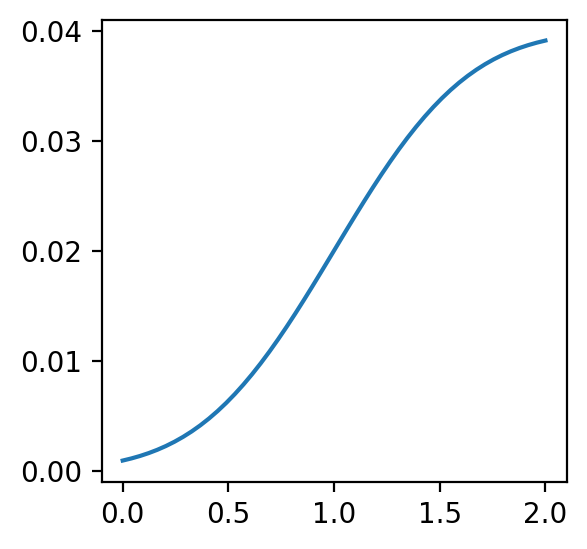

In [22]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(position, p);

## Helper functions

In [23]:
def kl_div_dirichlet(alpha_coeff, beta_coeff):
    """
        https://statproofbook.github.io/P/dir-kl.html
    """
    alpha_0 = np.sum(alpha_coeff)
    beta_0 = np.sum(beta_coeff)
    kl = (
        gammaln(alpha_0)
        - gammaln(beta_0)
        - np.sum(gammaln(alpha_coeff))
        + np.sum(gammaln(beta_coeff))
        + np.sum((alpha_coeff - beta_coeff) * (digamma(alpha_coeff) - digamma(alpha_0)))
    )
    return kl

# Pragmatic value focused

In [24]:
horizon = 6

# For logs
hist_pos, hist_vel = np.zeros((n_sample_run, n_timestep)), np.zeros((n_sample_run, n_timestep))

# For each sample...
for sample in range(n_sample_run):

    p_idx = np.absolute(position).argmin()  # Something close to 0
    v_idx = np.absolute(velocity).argmin() # Something close to 0

    np.random.seed(123 + sample*123)

    for t_idx in range(n_timestep):

        h = min(horizon, n_timestep - t_idx)
        action_plan = list(itertools.product(range(n_action), repeat=h))

        pragmatic = np.zeros(len(action_plan))
        for ap_index, ap in enumerate(action_plan):

            qvs = np.zeros((h, n_velocity))
            qps = np.zeros((h, n_position))

            qv = np.zeros(n_velocity)
            qv[v_idx] = 1.
            qp = np.zeros(n_position)
            qp[p_idx] = 1.

            for h_idx in range(h):
                a = ap[h_idx]
                qv = qp @ (qv @ transition_velocity_tapvv[t_idx + h_idx, a, :, :, :])
                qp = qp @ (qv @ transition_position_pvp)
                qvs[h_idx] = qv
                qps[h_idx] = qp

            pragmatic[ap_index] = np.sum(qps @ log_prior)

        a = action_plan[np.argmax(pragmatic)][0]

        v_idx = np.random.choice(np.arange(n_velocity), p=transition_velocity_tapvv[t_idx, a, p_idx, v_idx, :])
        p_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[p_idx, v_idx, :])

        hist_pos[sample, t_idx] = position[p_idx]
        hist_vel[sample, t_idx] = velocity[v_idx]

policy = "af-pragmatic"
if policy not in policies:
    policies.append(policy)
all_hist_pos[policy] = hist_pos
all_hist_vel[policy] = hist_vel


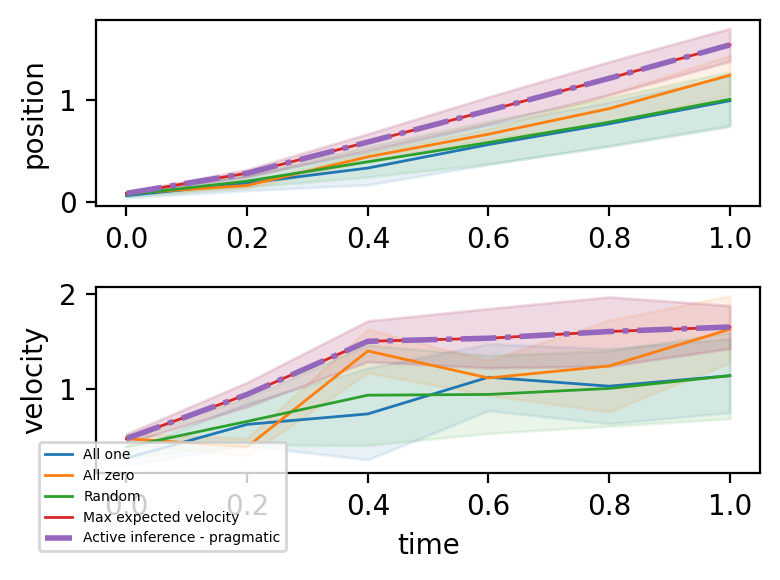

In [25]:
plot_runs(policies, all_hist_pos, all_hist_vel)

# Epistemic value

In [26]:
def q_transition_velocity(alpha):
    sum_col = np.sum(alpha, axis=-1)
    sum_col[sum_col <= 0.] = 1
    return alpha / np.expand_dims(sum_col, axis=-1)

In [27]:
all_hist_err = {}
policies_err = []

In [28]:
n_episode = 200
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    alpha_tapvv = np.zeros((n_timestep, n_action, n_position, n_velocity, n_velocity)) + np.finfo(np.float64).eps

    if sample == 0:
        error = np.mean((
            transition_velocity_tapvv - q_transition_velocity(alpha_tapvv))**2)
        print(f"Initial error {error:.2f}")

    epoch = 0
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        p_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin() # Something close to 0

        action_plan = np.random.randint(n_action, size=n_timestep)

        for t_idx, t in enumerate(timestep):

            # Pick new action and draw new velocity
            a = action_plan[t_idx]
            tr_vel = transition_velocity_tapvv[t_idx, a, p_idx, v_idx, :]
            new_v_index = np.random.choice(np.arange(n_velocity), p=tr_vel)

            # Update alpha
            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tapvv[t_idx, a, p_idx, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            tr_pos = transition_position_pvp[p_idx, v_idx, :]
            p_idx = np.random.choice(np.arange(n_position), p=tr_pos)

            # Log
            error = np.mean((transition_velocity_tapvv - q_transition_velocity(alpha_tapvv))**2)
            # print(error)
            hist_err[sample, epoch] = error
            epoch += 1

    print(f"[Sample {sample}] Error after {epoch} epochs {error:.6f}")

policy = "random"
if policy not in policies_err:
    policies_err.append(policy)
all_hist_err[policy] = hist_err

Initial error 0.03
[Sample 0] Error after 1200 epochs 0.029310
[Sample 1] Error after 1200 epochs 0.029302
[Sample 2] Error after 1200 epochs 0.029297
[Sample 3] Error after 1200 epochs 0.029331
[Sample 4] Error after 1200 epochs 0.029317
[Sample 5] Error after 1200 epochs 0.029347
[Sample 6] Error after 1200 epochs 0.029360
[Sample 7] Error after 1200 epochs 0.029343
[Sample 8] Error after 1200 epochs 0.029370
[Sample 9] Error after 1200 epochs 0.029329
[Sample 10] Error after 1200 epochs 0.029346
[Sample 11] Error after 1200 epochs 0.029349
[Sample 12] Error after 1200 epochs 0.029282
[Sample 13] Error after 1200 epochs 0.029340
[Sample 14] Error after 1200 epochs 0.029322
[Sample 15] Error after 1200 epochs 0.029334
[Sample 16] Error after 1200 epochs 0.029357
[Sample 17] Error after 1200 epochs 0.029340
[Sample 18] Error after 1200 epochs 0.029314
[Sample 19] Error after 1200 epochs 0.029300


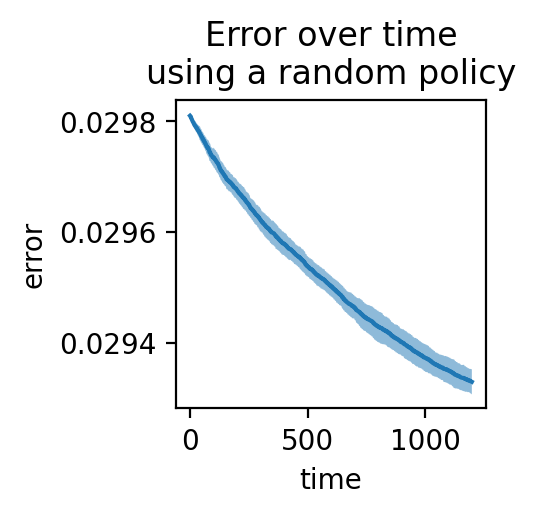

In [29]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(hist_err.mean(axis=0))
ax.fill_between(np.arange(n_episode*n_timestep),
                hist_err.mean(axis=0) - hist_err.std(axis=0),
                hist_err.mean(axis=0) + hist_err.std(axis=0),
                alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("error")
ax.set_title("Error over time\nusing a random policy");

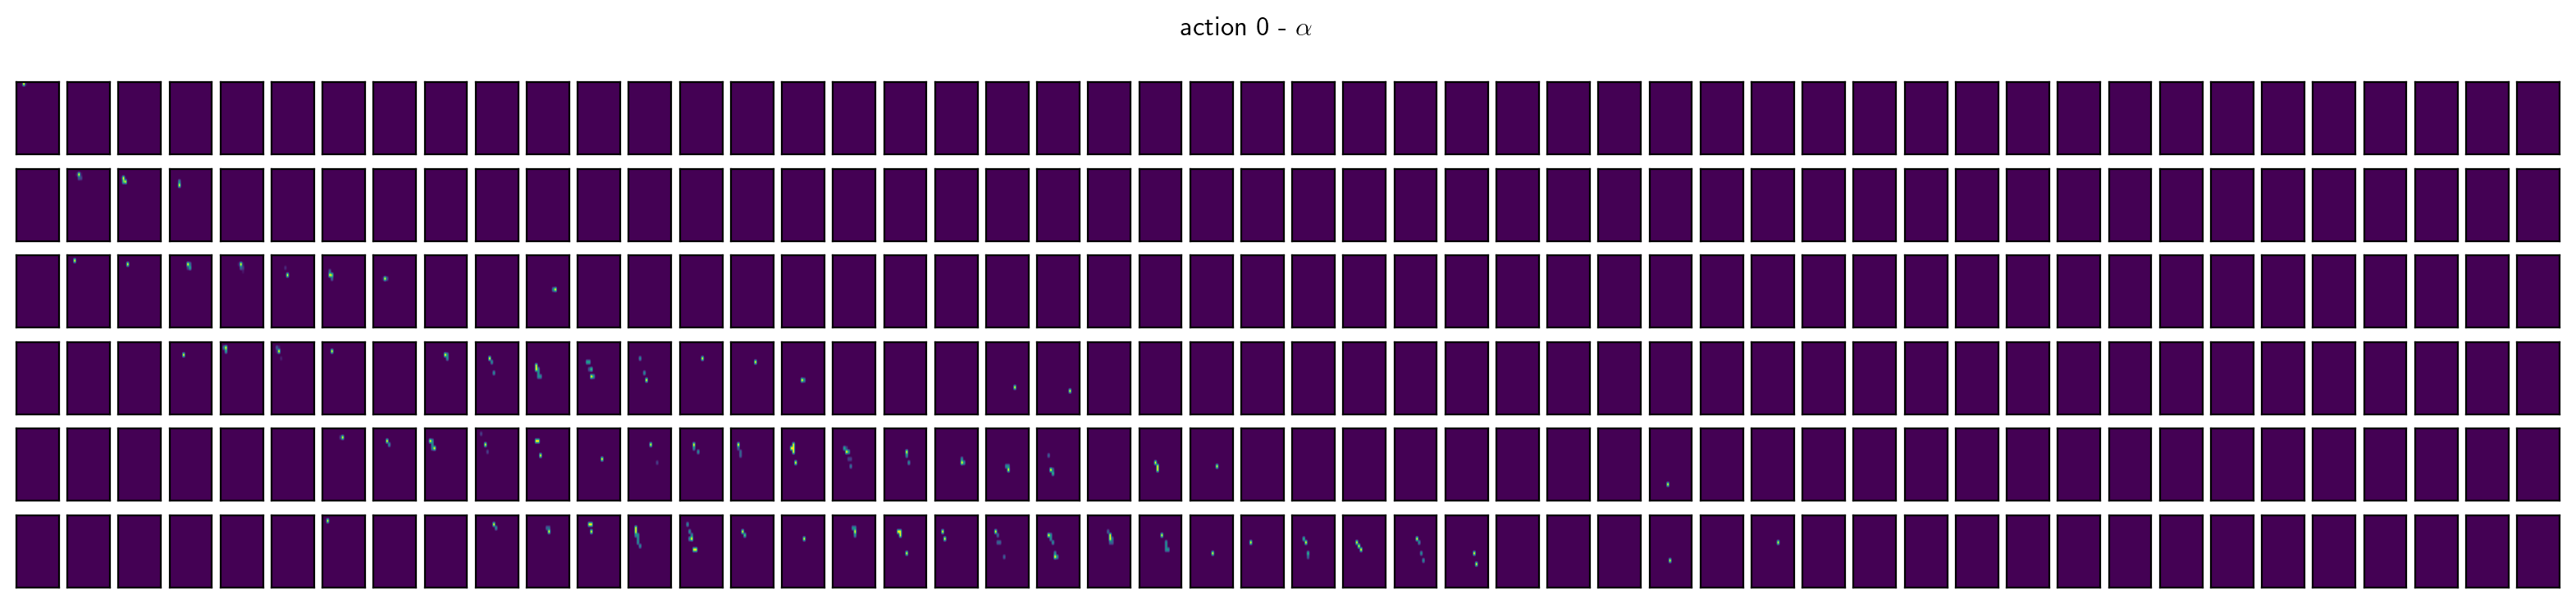

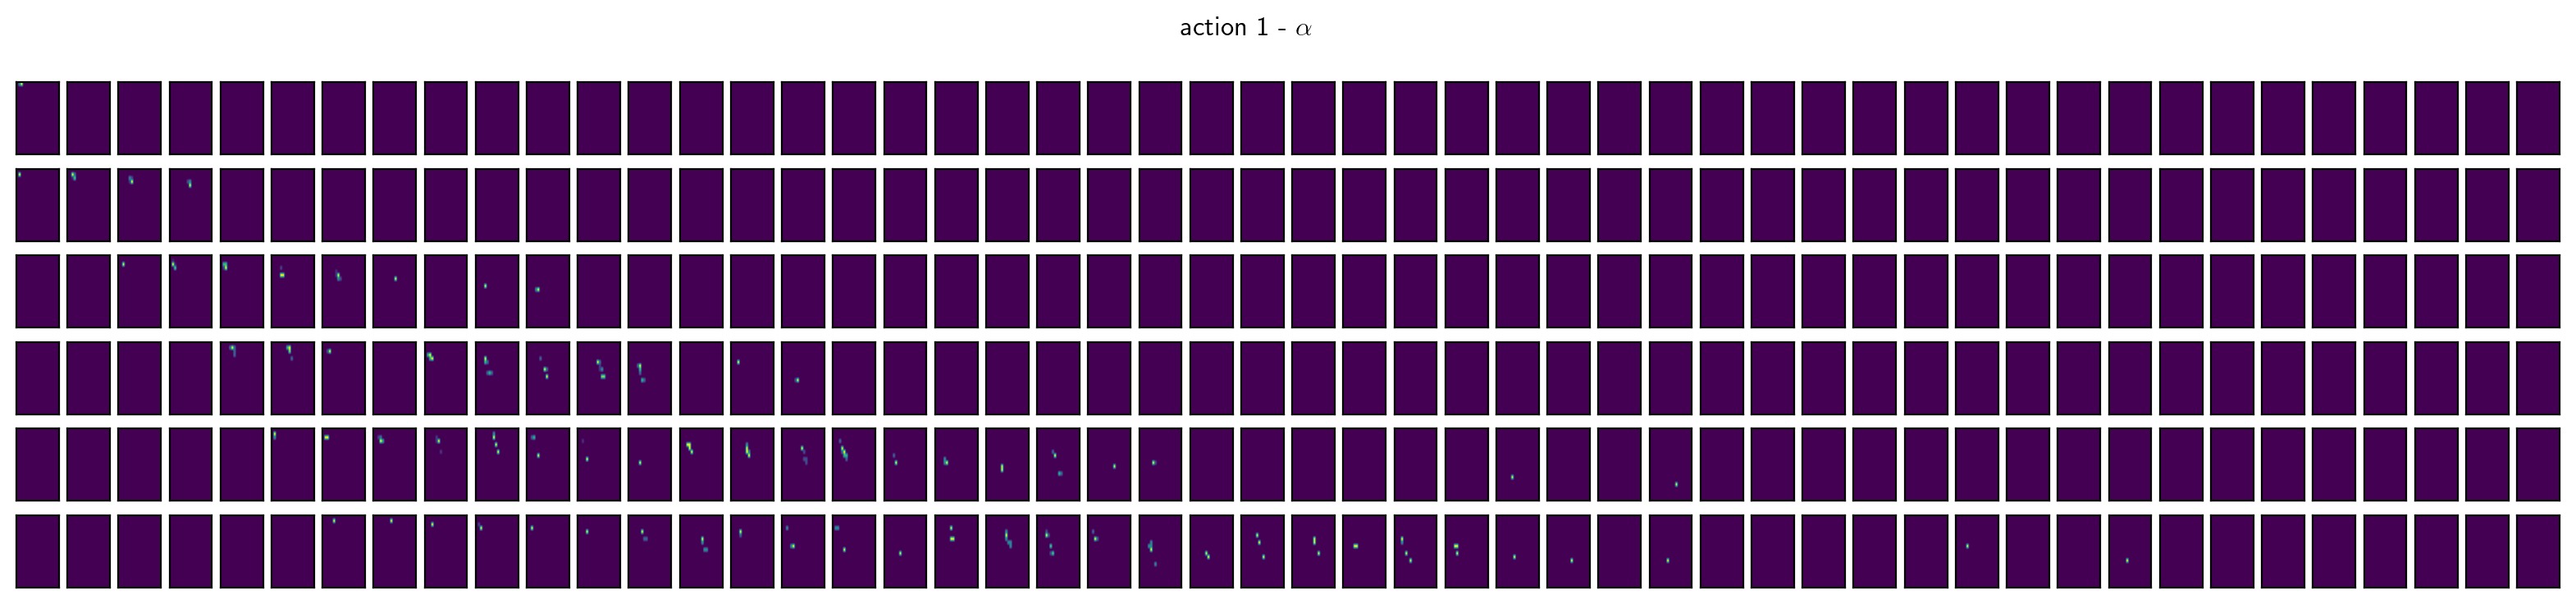

In [30]:
plt.rcParams['text.usetex'] = True
for a_idx in range(2):
    fig, axes = plt.subplots(ncols=n_position, nrows=n_timestep, figsize=(20, 4))
    fig.suptitle(f"action {a_idx} - " + r"$\alpha$")

    for p_idx in range(n_position): 
        for t_idx in range(n_timestep):
            ax = axes[t_idx, p_idx]
            img = alpha_tapvv[t_idx, a_idx, p_idx, :, :]
            ax.imshow(img, aspect="auto")
            ax.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
    
    plt.plot()

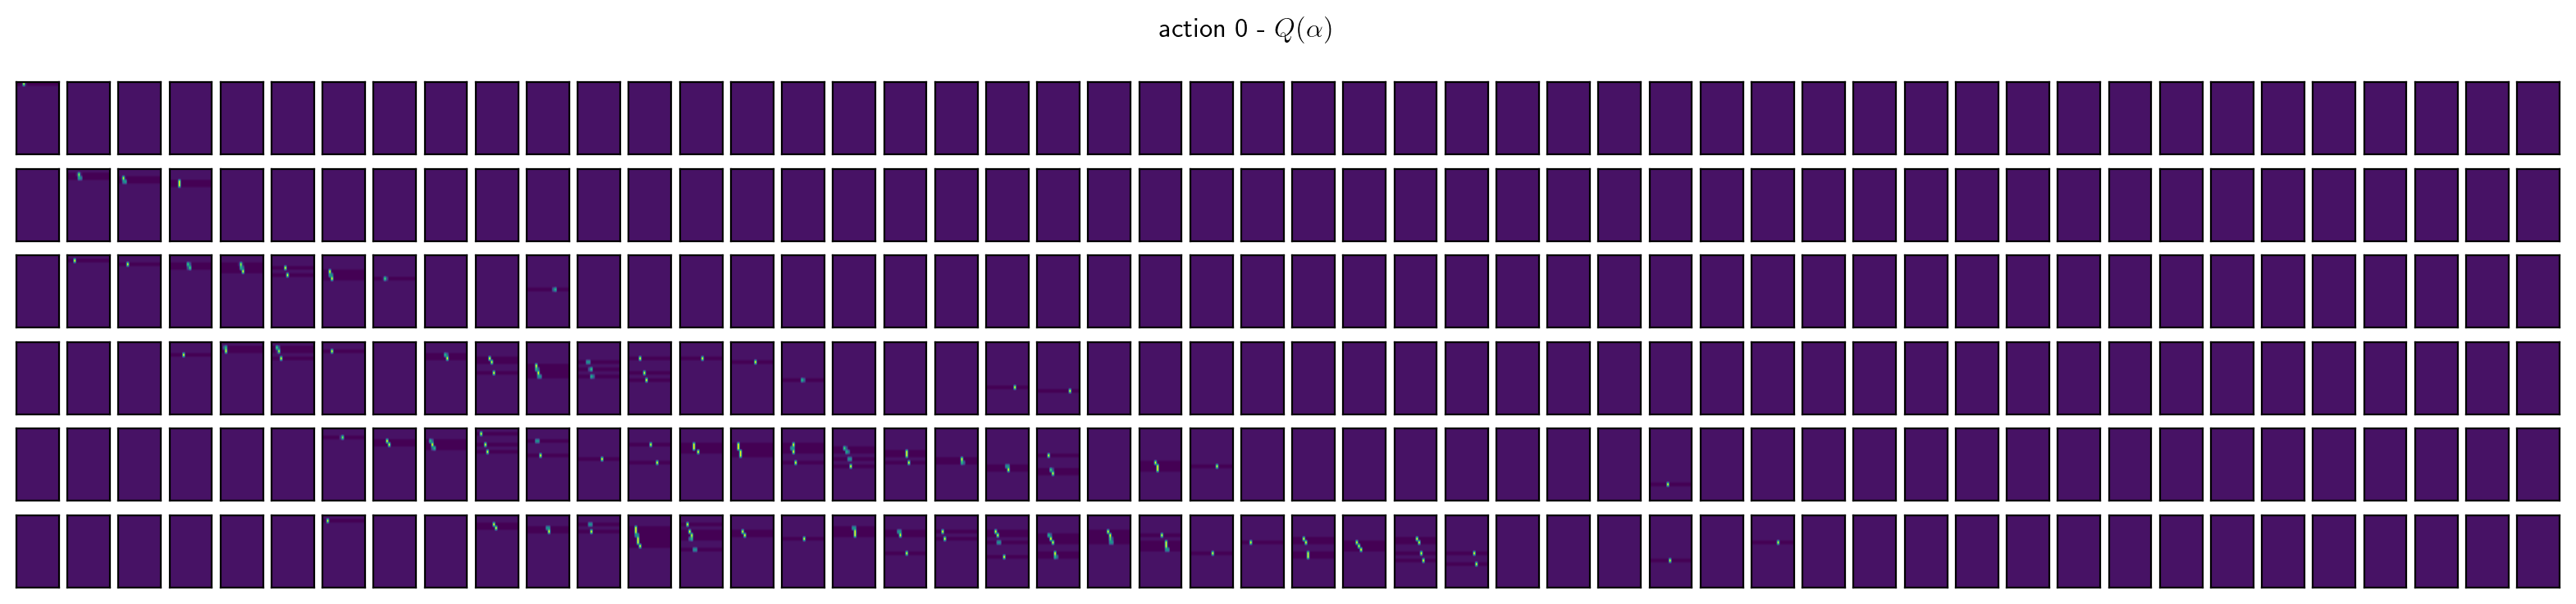

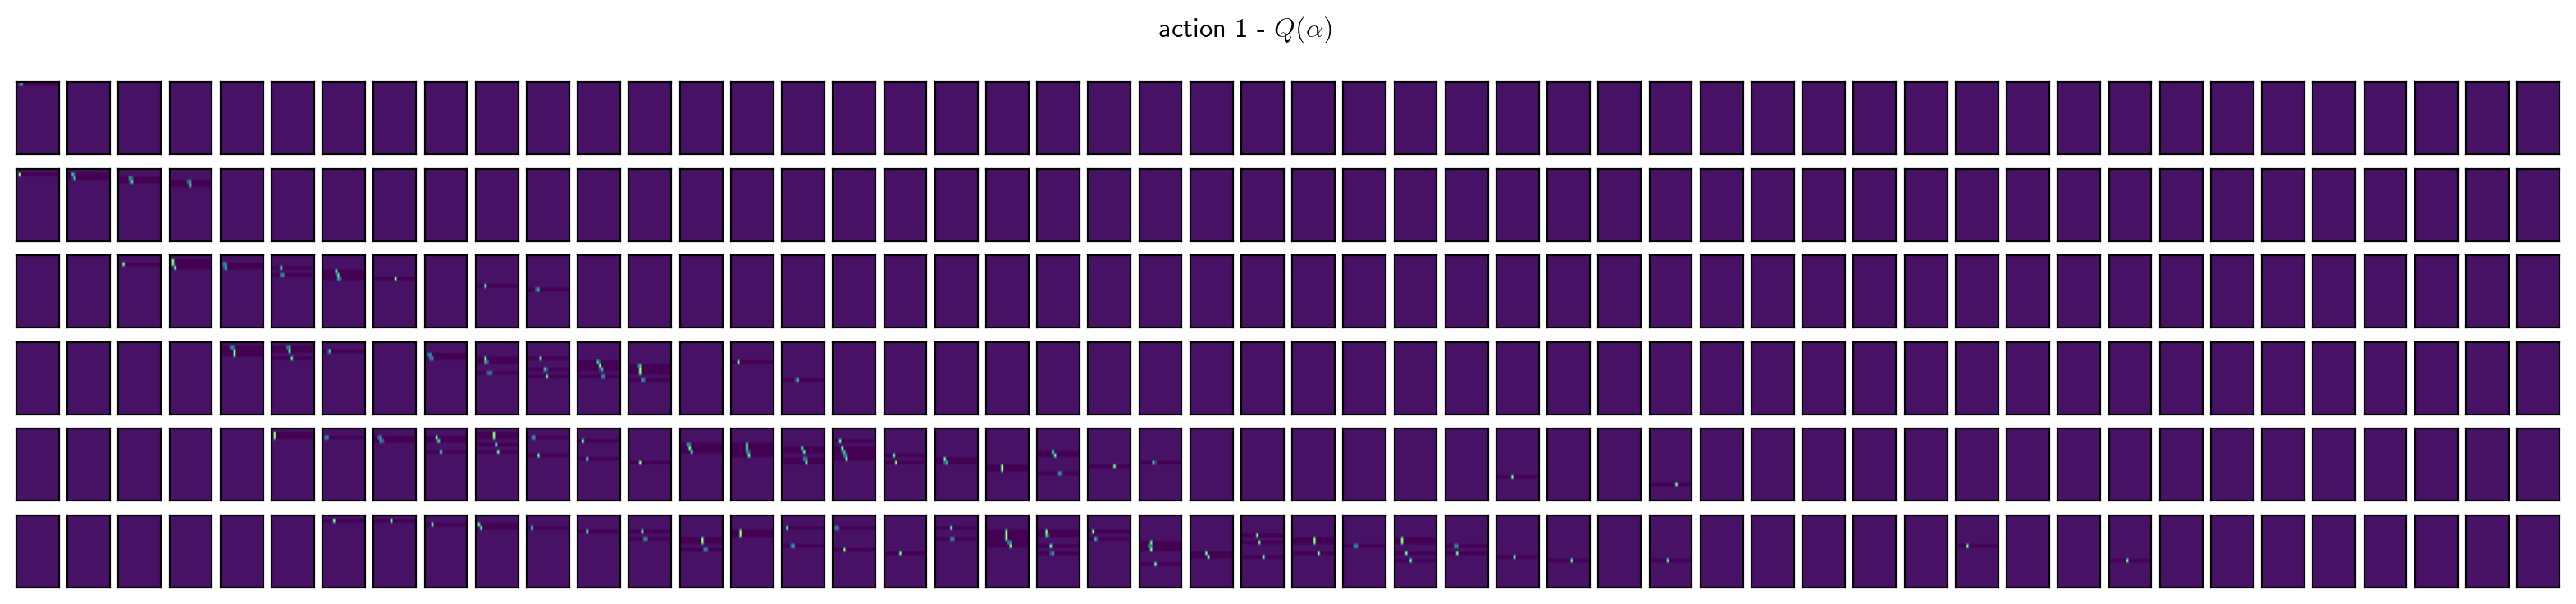

In [31]:
q = q_transition_velocity(alpha_tapvv)

plt.rcParams['text.usetex'] = True
for a_idx in range(2):
    fig, axes = plt.subplots(ncols=n_position, nrows=n_timestep, figsize=(20, 4))
    fig.suptitle(f"action {a_idx} - " + r"$Q(\alpha)$")

    for p_idx in range(n_position): 
        for t_idx in range(n_timestep):

            ax = axes[t_idx, p_idx]
            img = q[t_idx, a_idx, p_idx, :, :]
            ax.imshow(img, aspect="auto", vmin=0, vmax=1)
            ax.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])
    plt.plot()

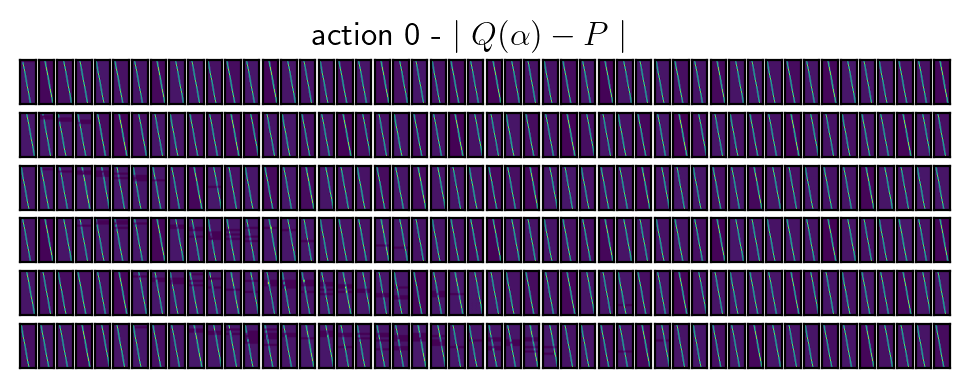

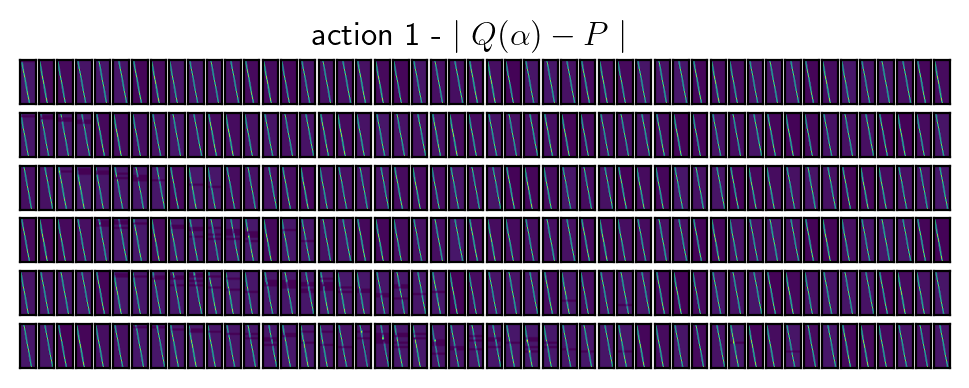

In [32]:
q = q_transition_velocity(alpha_tapvv)
diff = np.absolute(transition_velocity_tapvv - q)

plt.rcParams['text.usetex'] = True
for a_idx in range(2):
    fig, axes = plt.subplots(ncols=n_position, nrows=n_timestep,figsize=(6, 2))
    fig.suptitle(f"action {a_idx} - " + r"$\mid Q(\alpha) - P \mid$")

    for p_idx in range(n_position):
        for t_idx in range(n_timestep):
            ax = axes[t_idx, p_idx]
            img = diff[t_idx, a_idx, p_idx, :, :]
            ax.imshow(img, aspect="auto")
            ax.get_xaxis().set_ticks([])
            ax.axes.get_yaxis().set_ticks([])

    plt.show()

In [35]:
from task import run_epistemic
n_sample = 10
n_episode = 200
with tqdm(total=n_episode*n_timestep*n_sample) as pbar:
    hist_err = run_epistemic.run_task(
        pbar=pbar,
        horizon=n_timestep,
        position=position, velocity=velocity, timestep=timestep,
        transition_velocity_tapvv=transition_velocity_tapvv, 
        transition_position_pvp=transition_position_pvp, 
        n_episode=n_episode, n_sample=n_sample)

policy = "af-epistemic"
if policy not in policies_err:
    policies_err.append(policy)
all_hist_err[policy] = hist_err

100%|██████████| 12000/12000 [04:06<00:00, 48.62it/s]

[Sample 1] Error after 1200 epochs: 0.03
[Sample 1] Freq choose action 0: 39.50%
[Sample 4] Error after 1200 epochs: 0.03
[Sample 4] Freq choose action 0: 32.33%
[Sample 8] Error after 1200 epochs: 0.03
[Sample 8] Freq choose action 0: 37.17%
[Sample 7] Error after 1200 epochs: 0.03
[Sample 7] Freq choose action 0: 40.67%
[Sample 5] Error after 1200 epochs: 0.03
[Sample 5] Freq choose action 0: 30.33%
[Sample 2] Error after 1200 epochs: 0.03
[Sample 2] Freq choose action 0: 40.33%
[Sample 3] Error after 1200 epochs: 0.03
[Sample 3] Freq choose action 0: 30.50%
Initial error 0.03
[Sample 0] Error after 1200 epochs: 0.03
[Sample 0] Freq choose action 0: 38.92%
[Sample 9] Error after 1200 epochs: 0.03
[Sample 9] Freq choose action 0: 48.17%
[Sample 6] Error after 1200 epochs: 0.03
[Sample 6] Freq choose action 0: 33.25%


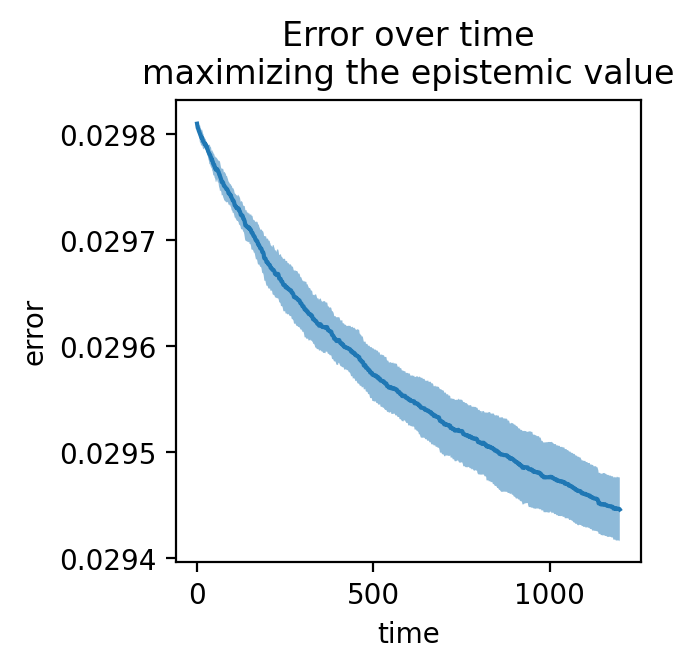

In [36]:
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(hist_err.mean(axis=0))
ax.fill_between(np.arange(len(hist_err.mean(axis=0))), hist_err.mean(axis=0) - hist_err.std(axis=0), hist_err.mean(axis=0) + hist_err.std(axis=0), alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("error")
ax.set_title("Error over time\nmaximizing the epistemic value");

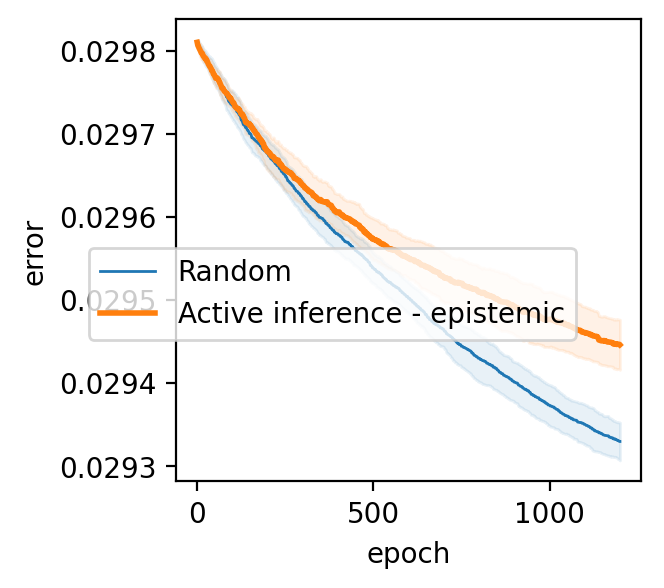

In [37]:
fig, ax = plt.subplots(figsize=(3, 3))
for i, policy in enumerate(policies_err):
    label = policy.replace("-", " ").capitalize()
    hist_err_mean = all_hist_err[policy].mean(axis=0)
    x = np.arange(len(hist_err_mean))
    hist_err_std = all_hist_err[policy].std(axis=0)

    if label.startswith("Af"):
        label = label.replace("Af", "Active inference -")
        linestyle, linewidth = "-", 2
    else:
        linestyle, linewidth = "-", 1
    ax.plot(x, hist_err_mean, color=f"C{i}", label=label, linestyle=linestyle, linewidth=linewidth)
    ax.fill_between(x, hist_err_mean - hist_err_std, hist_err_mean + hist_err_std, alpha=0.1, color=f"C{i}")
    ax.set_ylabel("error")
    ax.set_xlabel("epoch")

fig.legend(loc="center");